In [1]:
import pandas
pandas.options.display.max_columns = 35
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [17]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_validate, \
                                    cross_val_predict, learning_curve, validation_curve
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper
import cloudpickle as pickle

import xgboost

In [29]:
train = pandas.read_csv("data/train.csv", index_col="PassengerId")
X_test = pandas.read_csv("data/test.csv", index_col="PassengerId")

In [30]:
y = train.loc[:, ['Survived']]
X = train.loc[:, [c for c in train.columns if c != 'Survived']]

In [26]:
predict = pandas.DataFrame(index=X_test.index)

## some handy helper functions

In [7]:
def report(y_true, y_pred):
    """wrapper function for reporting classification results.
    
    ARGS:
        y_true: array-like.
            True binary labels.
        y_pred: array-like.
            predicted binary labels.
    """
    print(metrics.classification_report(y_true, y_pred))
    
    cm = metrics.confusion_matrix(y_true, y_pred)
    cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    fig = sb.heatmap(cmn, vmin=0, vmax=1, cmap='Blues', annot=True)
    fig.set_xlabel('predicted')
    fig.set_ylabel('true')

In [8]:
from scipy import interp
def roc_cv(classifier, X, y, cv=10, stratified=True):
    """plotter utility for ROC curves under cross-validation.
    
    ARGS:
        classifier: `sklearn`-compliant classifier instance.
            defined classifier to generate ROC curve.  Must implement `predict_proba`.
        X: array-like.
            input data to be passed to K-fold splitter, of shape (n_samples, n_features)
        y: array-like.
            target data to be passed to K-fold splitter, of shape (n_samples,)
            
    KWARGS:
        cv: int.
            number of folds for cross-validation.  Defaults to 5.
        stratified: boolean.
            set True to use stratified K-folding.  Defaults to True.
    """
    if type(X) is pandas.DataFrame:
        X = X.values
    if type(y) is pandas.Series:
        y = y.values
    
    if stratified:
        folder = StratifiedKFold(n_splits=cv)
    else:
        folder = KFold(n_splits=cv)

    aucs = []
    tpr_interp = []
    fpr_interp = np.linspace(0,1,100)
    fig = plt.figure(figsize=(8,8))
    for train, test in folder.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = metrics.roc_curve(y[test], probas_[:, 1])
        tpr_interp.append(interp(fpr_interp, fpr, tpr))
        tpr_interp[-1][0] = 0.0
        aucs.append(metrics.auc(fpr, tpr))
        plt.plot(fpr, tpr, lw=1, alpha=0.8)
        
    mean_tpr = np.mean(tpr_interp, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tpr_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(fpr_interp, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    plt.plot(fpr_interp, mean_tpr, lw=2, color='b')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
    plt.text(0.55, 0.2, "avg AUC: {:.3f}".format(np.mean(aucs)), fontsize=16)

In [9]:
def learning_curve_cv(estimator, X, y, 
                      cv=10, 
                      n_jobs=1, 
                      train_sizes=np.linspace(.1, 1.0, 5),
                      scoring="accuracy",
                      y_lim=[0,1]):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv,
                                                            n_jobs=n_jobs,
                                                            train_sizes=train_sizes)
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_std = test_scores.std(axis=1)
    
    fig = plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="training scores")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="testing scores")
    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, 
                     alpha=0.1, 
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, 
                     alpha=0.1, 
                     color="g")
    plt.ylim(y_lim)
    plt.xlabel("training samples")
    plt.ylabel(scoring)
    plt.legend(loc="lower right")

### Logistic Regression Classifier

In [40]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
scaler = StandardScaler()

In [19]:
with open("mapper.pkl", "rb") as rf:
    mapper = pickle.load(rf)

In [32]:
X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [35]:
mapper.transform(X).head(10)

,Sex,Pclass,ClassXSex,FamilySize_large,FamilySize_small,FamilySize_solo,FarePerPerson,Age,IsChild,Embarked_C,Embarked_Q,Embarked_S,Embarked_unknown,Title_men,Title_noble,Title_other,Title_women,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_no_cabin
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,3,6,0,1,0,3.62500,22.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1,1,0,1,0,35.64165,38.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
3,0,3,3,0,0,1,7.92500,26.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0,1,1,0,1,0,26.55000,35.0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
5,1,3,6,0,0,1,8.05000,35.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
6,1,3,6,0,0,1,8.45830,25.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
7,1,1,4,0,0,1,51.86250,54.0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
8,1,3,6,1,0,0,4.21500,2.0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
9,0,3,3,0,1,0,3.71110,27.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [65]:
selector = DataFrameMapper(features=[
    ("ClassXSex", None),
    ("FamilySize_large", None),
    ("FamilySize_small", None),
    ("FamilySize_solo", None),
    ("FarePerPerson", None),
    ("Age", None),
    ("Embarked_C", None),
    ("Embarked_Q", None),
    ("Embarked_S", None),
    ("Embarked_unknown", None),
    ("Title_men", None),
    ("Title_women", None),
    ("Title_other", None),
    ("Title_noble", None),
    ("Deck_A", None),
    ("Deck_B", None),
    ("Deck_C", None),
    ("Deck_D", None),
    ("Deck_E", None),
    ("Deck_F", None),
    ("Deck_G", None),
    ("Deck_T", None),
    ("Deck_no_cabin", None)
], input_df=True, df_out=True)

In [66]:
selector.fit_transform(mapper.transform(X)).head(10)

,ClassXSex,FamilySize_large,FamilySize_small,FamilySize_solo,FarePerPerson,Age,Embarked_C,Embarked_Q,Embarked_S,Embarked_unknown,Title_men,Title_women,Title_other,Title_noble,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_no_cabin
PassengerId,,,,,,,,,,,,,,,,,,,,,,,
1,6,0,1,0,3.62500,22.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,1,0,1,0,35.64165,38.0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,3,0,0,1,7.92500,26.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,1,0,1,0,26.55000,35.0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
5,6,0,0,1,8.05000,35.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
6,6,0,0,1,8.45830,25.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
7,4,0,0,1,51.86250,54.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
8,6,1,0,0,4.21500,2.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
9,3,0,1,0,3.71110,27.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [67]:
parameters = {
    "penalty": ["l1", "l2"],
    "C": [0.01, 0.1, 1, 10],
    "intercept_scaling": [1, 2],
    "class_weight": ["balanced", None]
}
gscv = GridSearchCV(LogisticRegression(), 
                    parameters, 
                    cv=10, 
                    n_jobs=6, 
                    verbose=1, 
                    return_train_score=True,
                    scoring="accuracy")

In [68]:
gscv.fit(scaler.fit_transform(selector.transform(mapper.transform(X))), y.Survived)

/Users/john/python/kaggle-titanic/venv/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/john/python/kaggle-titanic/venv/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=6)]: Done 320 out of 320 | elapsed:    1.0s finished
/Users/john/python/kaggle-titanic/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'intercept_scaling': [1, 2], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [69]:
gscv.best_score_

0.8181818181818182

In [70]:
gscv.best_params_

{'C': 10, 'class_weight': None, 'intercept_scaling': 1, 'penalty': 'l1'}

In [71]:
parameters = {
    "penalty": ["l2"],
    "C": [0.8, 1, 1.25, 1.5, 2],
    "intercept_scaling": [1],
    "class_weight": [None]
}
gscv = GridSearchCV(LogisticRegression(), 
                    parameters, 
                    cv=10, 
                    n_jobs=6, 
                    verbose=1, 
                    return_train_score=True,
                    scoring="accuracy")

In [72]:
gscv.fit(scaler.transform(selector.transform(mapper.transform(X))), y.Survived)

/Users/john/python/kaggle-titanic/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.6s finished
/Users/john/python/kaggle-titanic/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid={'penalty': ['l2'], 'C': [0.8, 1, 1.25, 1.5, 2], 'intercept_scaling': [1], 'class_weight': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [73]:
print(gscv.best_params_)
print(gscv.best_score_)

{'C': 2, 'class_weight': None, 'intercept_scaling': 1, 'penalty': 'l2'}
0.8181818181818182


In [74]:
lr = gscv.best_estimator_

/Users/john/python/kaggle-titanic/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


              precision    recall  f1-score   support

           0       0.84      0.87      0.85       549
           1       0.77      0.73      0.75       342

   micro avg       0.81      0.81      0.81       891
   macro avg       0.80      0.80      0.80       891
weighted avg       0.81      0.81      0.81       891



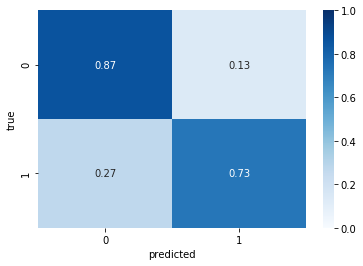

In [75]:
report(y.Survived, cross_val_predict(LogisticRegression(C=1, class_weight=None, penalty="l2"),
                                     scaler.transform(selector.transform(mapper.transform(X))),
                                     y.Survived,
                                     cv=8,
                                     n_jobs=5))

In [76]:
scores = cross_validate(LogisticRegression(C=1, class_weight=None, penalty="l2"),
                        scaler.transform(selector.transform(mapper.transform(X))), 
                        y.Survived, 
                        scoring="accuracy", 
                        cv=8, 
                        n_jobs=-1, 
                        return_train_score=True)
print("training: {} +/- {}".format(scores['train_score'].mean(), scores['train_score'].var()))
print("validation: {} +/- {}".format(scores['test_score'].mean(), scores['test_score'].var()))

/Users/john/python/kaggle-titanic/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


training: 0.8268396178077468 +/- 1.3629051410789013e-05
validation: 0.8137294152919152 +/- 0.0003986253787659228


/Users/john/python/kaggle-titanic/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


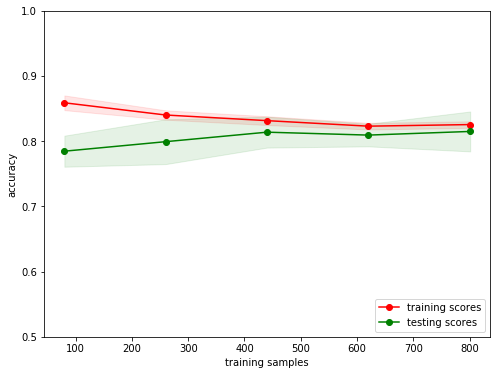

In [77]:
learning_curve_cv(LogisticRegression(C=1, class_weight=None, penalty="l2", solver='lbfgs'), 
                  scaler.transform(selector.transform(mapper.transform(X))), 
                  y.Survived, 
                  y_lim=[0.5, 1])

/Users/john/python/kaggle-titanic/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


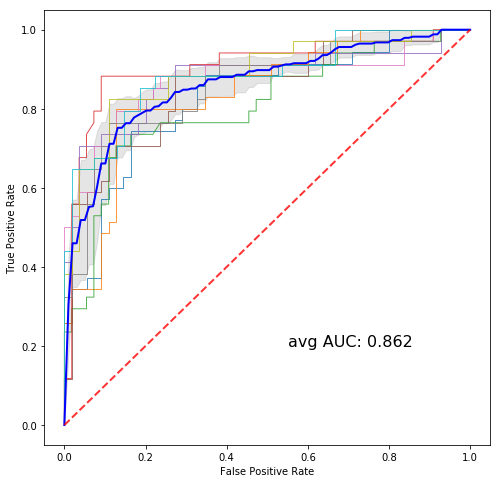

In [78]:
roc_cv(LogisticRegression(C=1, class_weight=None, penalty="l2", solver='lbfgs'), 
       scaler.transform(selector.transform(mapper.transform(X))), 
       y.Survived)

In [79]:
y['lr_predict_proba'] = cross_val_predict(LogisticRegression(C=1, class_weight=None, penalty="l2", solver='lbfgs'),
                                          scaler.transform(selector.transform(mapper.transform(X))),
                                          y.Survived,
                                          cv=10,
                                          n_jobs=6,
                                          method='predict_proba')[:,1]

/Users/john/python/kaggle-titanic/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


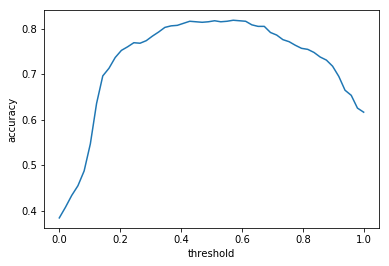

In [80]:
threshold = np.linspace(0,1,50)
accuracies = []
for t in threshold:
    accuracies.append(metrics.accuracy_score(y.Survived, y.lr_predict_proba >= t))
    
plt.plot(threshold, accuracies);
plt.xlabel("threshold");
plt.ylabel("accuracy");

In [81]:
print("best accuracy: {:.4f}".format(np.max(accuracies)))
print("best threshold: {:.4f}".format(threshold[np.argmax(accuracies)]))

best accuracy: 0.8182
best threshold: 0.5714


In [84]:
predict['Survived'] = (lr.predict(scaler.transform(selector.transform(mapper.transform(X_test))))).astype(int)

/Users/john/python/kaggle-titanic/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [85]:
predict.to_csv("predictions/logistic_regression.csv")

In [86]:
pandas.DataFrame(list(zip(X.columns, lr.coef_[0, :]))).sort_values(by=1)

,0,1
0,Pclass,-1.561773
5,Parch,-0.563053
1,Name,-0.474291
8,Cabin,-0.072016
7,Fare,0.010563
6,Ticket,0.050728
3,Age,0.079527
4,SibSp,0.108159
2,Sex,0.174198
9,Embarked,0.199169


In [87]:
pipe = Pipeline(memory=None,
                steps=[
                    ("FeatureEngineer", mapper),
                    ("FeatureFilter", selector),
                    ('StandardScaler', StandardScaler()),
                    ("logistic", LogisticRegression(C=1, class_weight=None, penalty="l2", solver='lbfgs'))
                ])

In [88]:
pipe.fit(X, y.Survived)

/Users/john/python/kaggle-titanic/venv/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/john/python/kaggle-titanic/venv/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('FeatureEngineer', DataFrameMapper(default=False, df_out=True,
        features=[('Sex', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False), {}), ('Pclass', None, {}), (['Sex', 'Pclass'], <__main__.ClassSexTransformer object at 0x10e0aa048>, {'alias': 'ClassXSex'}), (['Parch', 'Si...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [89]:
predict['Survived'] = pipe.predict(X_test)

/Users/john/python/kaggle-titanic/venv/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [90]:
predict.to_csv("predictions/logistic_regression.csv")

In [93]:
with open('pipeline.pkl', 'wb') as wf:
    pickle.dump(pipe, wf)

### random forest

In [ ]:
parameters = {
    "n_estimators": [50, 100, 500],
    "max_features": ["auto", None],
    "max_depth": [5, 10, None],
    "min_samples_split": [8, 10, 12],
    "class_weight": ["balanced", None]
}
gscv = GridSearchCV(RandomForestClassifier(), 
                    parameters, 
                    cv=10, 
                    n_jobs=6, 
                    verbose=1, 
                    return_train_score=True,
                    scoring="accuracy")
gscv.fit(X, y.Survived)

In [ ]:
print(gscv.best_params_)
print(gscv.best_score_)

In [ ]:
parameters = {
    "n_estimators": [75, 100, 125, 150],
    "max_features": [None],
    "max_depth": [5, 10, None],
    "min_samples_split": [8, 10],
    "class_weight": ["balanced", None]
}
gscv = GridSearchCV(RandomForestClassifier(), 
                    parameters, 
                    cv=10, 
                    n_jobs=6, 
                    verbose=1, 
                    return_train_score=True,
                    scoring="accuracy")
gscv.fit(X, y.Survived)

In [ ]:
print(gscv.best_params_)
print(gscv.best_score_)

In [ ]:
parameters = {
    "n_estimators": [125, 150, 175],
    "max_features": [None],
    "max_depth": [8, 10, 12],
    "min_samples_split": [8, 10, 12],
    "class_weight": ["balanced"]
}
gscv = GridSearchCV(RandomForestClassifier(), 
                    parameters, 
                    cv=10, 
                    n_jobs=6, 
                    verbose=1, 
                    return_train_score=True,
                    scoring="accuracy")
gscv.fit(X, y.Survived)

In [ ]:
print(gscv.best_params_)
print(gscv.best_score_)

In [ ]:
params = {
    "n_estimators": 50,
    "max_depth": 5,
    "min_samples_split": 10,
    "class_weight": None,
    "max_features": "auto"
}

scores = cross_validate(RandomForestClassifier(**params),
                        X, 
                        y.Survived, 
                        scoring="accuracy", 
                        cv=8, 
                        n_jobs=-1, 
                        return_train_score=True)
print("training: {} +/- {}".format(scores['train_score'].mean(), scores['train_score'].var()))
print("validation: {} +/- {}".format(scores['test_score'].mean(), scores['test_score'].var()))

In [ ]:
learning_curve_cv(RandomForestClassifier(**params),
                  X,
                  y.Survived, 
                  y_lim=[0.5, 1])

this feels like it's overfitting a bit...

In [ ]:
rfr = RandomForestClassifier(**params).fit(X, y.Survived)
predict['Survived'] = rfr.predict(X_test)
predict.to_csv("predictions/random_forest.csv")